In [1]:
from gremlin_python.driver import client
print("gremlin_python import 성공!")


gremlin_python import 성공!


In [2]:
import nest_asyncio
nest_asyncio.apply() #runtime error방지 중첩실행 가능하게 

from gremlin_python.driver import client, serializer 

#gremlin python 서버와의 연결하는 client객체 생성
gremlin_client = client.Client(
    'ws://localhost:8182/gremlin', 
    'g',
    username="", #인증 필요없을 경우 비워둠 
    password="",
    message_serializer=serializer.GraphSONSerializersV2d0()
)

#서버가 실행 중이어야 하고, 포트가 열려 있어야 정상 동작함, 오류 발생시 서버 로그 또는 방화벽 점검 



In [3]:
# 노드 및 엣지 생성 (기존에 존재하지 않을 경우)
queries = [
    # 사용자 노드 생성: user_id는 'u001', 이름은 'Alice'
    "g.addV('user').property('user_id', 'u001').property('name', 'Alice')",

    # 디바이스 노드 생성: device_id는 'd001', 타입은 'mobile'
    "g.addV('device').property('device_id', 'd001').property('type', 'mobile')",

    # IP 노드 생성
    "g.addV('ip').property('ip_addr', '192.168.1.10')",

    # 거래 노드 생성
    "g.addV('transaction').property('tx_id', 't001').property('amount', 1200)",

    # 가맹점 노드 생성
    "g.addV('merchant').property('merchant_id', 'm001').property('name', 'LuxuryStore')",

    # 사용자 → 디바이스 관계 생성 (uses 엣지)
    "g.V().has('user', 'user_id', 'u001').as('u').V().has('device', 'device_id', 'd001').addE('uses').from('u')",

    # 사용자 → IP 관계 생성 (logs_in_from 엣지)
    "g.V().has('user', 'user_id', 'u001').as('u').V().has('ip', 'ip_addr', '192.168.1.10').addE('logs_in_from').from('u')",

    # 사용자 → 거래 관계 생성 (initiates 엣지)
    "g.V().has('user', 'user_id', 'u001').as('u').V().has('transaction', 'tx_id', 't001').addE('initiates').from('u')",

    # 거래 → 가맹점 관계 생성 (pays_to 엣지)
    "g.V().has('transaction', 'tx_id', 't001').as('t').V().has('merchant', 'merchant_id', 'm001').addE('pays_to').from('t')"
]

for q in queries:
    gremlin_client.submit(q).all().result()



In [4]:
pip install networkx matplotlib 


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


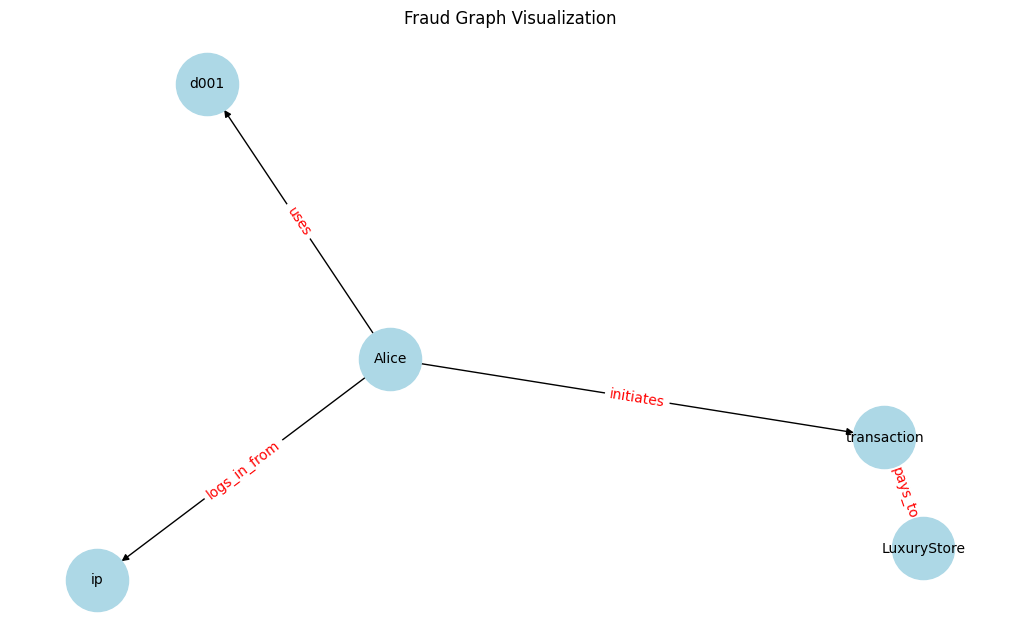

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# 노드 가져오기
nodes = gremlin_client.submit("g.V().elementMap()").all().result()

# 엣지 정보 가져오기 (id, label, outV, inV)
edges = gremlin_client.submit("""
g.E().project('id', 'label', 'outV', 'inV')
     .by(id)
     .by(label)
     .by(outV().id())
     .by(inV().id())
""").all().result()

# NetworkX 그래프 생성
G = nx.DiGraph()

# 노드 추가
for node in nodes:
    node_id = node['id']
    label = node['label']
    props = {k: v[0] if isinstance(v, list) else v for k, v in node.items() if k not in ('id', 'label')}
    display = props.get('name') or props.get('user_id') or props.get('device_id') or label
    G.add_node(node_id, label=label, display=display)

# 엣지 추가
for edge in edges:
    G.add_edge(edge['outV'], edge['inV'], label=edge['label'])

# 시각화
pos = nx.spring_layout(G)
node_labels = nx.get_node_attributes(G, 'display')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='lightblue', node_size=2000, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title("Fraud Graph Visualization")
plt.show()


In [6]:
# 유저 u001이 사용한 디바이스와 IP 수를 기준으로 의심 패턴 판단

# 유저 u001이 사용한 디바이스 수를 계산
user_id = 'u001'

device_count = gremlin_client.submit(f"""
    g.V().has('user', 'user_id', '{user_id}').
    out('uses').count()
""").all().result()[0]
# 1.user_id에 해당하는 사용자 정점(Vertex)을 찾음
# 2.해당 사용자가 'uses' 엣지를 통해 연결된 디바이스 정점들로 이동
# 3. 연결된 디바이스 정점의 개수를 셈
# 4. 결과는 리스트 형태로 오기 때문에 첫 번째 값([0])을 가져옴
#(user_id='u001') --[uses]--> (device1)
               # └──────────> (device2)


# 유저 u001이 사용한 IP 수를 계산
ip_count = gremlin_client.submit(f"""
    g.V().has('user', 'user_id', '{user_id}').
    out('logs_in_from').count()
""").all().result()[0]

# 유저 u001이 시작한 거래의 금액을 조회
amount = gremlin_client.submit(f"""
    g.V().has('user', 'user_id', '{user_id}').
    out('initiates').
    values('amount')
""").all().result()[0]

# 의심 거래 판단 로직: 여러 디바이스 or IP 사용 or 큰 금액
is_suspicious = device_count > 1 or ip_count > 1 or amount > 1000

# 결과 메시지 생성
if is_suspicious:
    explanation = f"""\
[의심 거래 감지] 유저 {user_id}는 {device_count}개의 디바이스와 {ip_count}개의 IP에서 접속했고, \
거래 금액은 ${amount}입니다. 이는 일반적인 행동 패턴을 벗어나므로 조사 대상입니다."""
else:
    explanation = f"[정상 거래] 유저 {user_id}의 행동은 정상 범위 내에 있습니다."

print(explanation)


[의심 거래 감지] 유저 u001는 1개의 디바이스와 1개의 IP에서 접속했고, 거래 금액은 $1200입니다. 이는 일반적인 행동 패턴을 벗어나므로 조사 대상입니다.


In [7]:
# 이상 거래 로그 예시
fraud_logs = [
    {
        "user": "u001",
        "ip": "192.168.1.10",
        "device": "d001",
        "tx_amount": 1200,
        "merchant": "LuxuryStore",
        "anomaly": "high_amount_new_device",
        "action": "alert_raised"
    }
]

# 설명 생성 함수 (LLM 없이 템플릿 기반)
def generate_fraud_explanation(log):
    explanation = (
        f"사용자 {log['user']}는 {log['device']} 장치를 통해 IP {log['ip']}에서 "
        f"{log['merchant']}에서 {log['tx_amount']}원 결제를 시도했습니다.\n"
        f"이 장치는 등록된 장치가 아니며, 금액이 비정상적으로 높아 이상 거래로 판단되었습니다.\n"
        f"조치: '{log['action']}'이 취해졌습니다."
    )
    return explanation

# 실행
for log in fraud_logs:
    print("이상 거래 설명:\n", generate_fraud_explanation(log))


이상 거래 설명:
 사용자 u001는 d001 장치를 통해 IP 192.168.1.10에서 LuxuryStore에서 1200원 결제를 시도했습니다.
이 장치는 등록된 장치가 아니며, 금액이 비정상적으로 높아 이상 거래로 판단되었습니다.
조치: 'alert_raised'이 취해졌습니다.
